In [1]:
import os
os.getcwd()

'C:\\Users\\sganguly\\OneDrive - EMBLEBI\\Nucleic acids project\\RNA_stats'

In [8]:
!pip install solrq
!pip install py3Dmol
!pip install rdkit


import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from solrq import Q  # For query formatting
# Define the PDBe API URL
search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"
# Set seaborn style
sns.set(style="whitegrid")

All ready, move to next code


,assembly_composition,entity_weight,experimental_method,interacting_ligands,journal,organism_scientific_name,pdb_id,processing_site,release_year,title
0,RNA/protein complex,579761.940,Electron Microscopy,"MG : MAGNESIUM ION,T1C : TIGECYCLINE",Nat Commun,Saccharomyces cerevisiae,8k82,PDBJ,2024,Cryo-EM structure of the yeast 80S ribosome wi...
1,RNA/protein complex,645.454,X-ray diffraction,MN : MANGANESE (II) ION,Elife,synthetic construct,7mpq,RCSB,2021,Bartonella henselae NrnC cleaving pGG in the p...
2,RNA/protein complex,497404.970,Electron Microscopy,"MG : MAGNESIUM ION,PUT : 1,4-DIAMINOBUTANE",Nature,Escherichia coli K-12,7n2u,RCSB,2021,Elongating 70S ribosome complex in a hybrid-H1...
3,RNA/protein complex,945314.250,Electron Microscopy,"MG : MAGNESIUM ION,YQM : Eravacycline",mBio,Acinetobacter baumannii AB0057,7m4w,RCSB,2021,A. baumannii Ribosome-Eravacycline complex: Em...
4,RNA/protein complex,579635.250,Electron Microscopy,MG : MAGNESIUM ION,Sci Adv,Saccharomyces cerevisiae,8evq,RCSB,2023,Hypopseudouridylated Ribosome bound with TSV I...
5,RNA/protein complex,38951.105,Electron Microscopy,MG : MAGNESIUM ION,Sci Adv,Saccharomyces cerevisiae,8evs,RCSB,2023,Hypopseudouridylated yeast 80S bound with Taur...
6,DNA/RNA/protein complex,9700.808,Electron Microscopy,G2P : PHOSPHOMETHYLPHOSPHONIC ACID GUANYLATE E...,Proc Natl Acad Sci U S A,synthetic RNA,8ej3,RCSB,2023,M. tuberculosis RNAP pause escaped complex wit...
7,RNA/protein complex,5842.595,Electron Microscopy,NaN,Nat Commun,Escherichia coli K-12,7lv0,RCSB,2021,Pre-translocation rotated ribosome +1-frameshi...
8,RNA/protein complex,15963.094,Electron Microscopy,NaN,Science,Trypanosoma brucei,8fnk,RCSB,2023,Cryo-EM structure of RNase-untreated RESC-B in...
9,DNA/RNA/protein complex,15404.284,Electron Microscopy,PRF : 7-DEAZA-7-AMINOMETHYL-GUANINE,Nat Struct Mol Biol,Escherichia coli,8g8z,RCSB,2023,Cryo-EM structure of 3DVA component 1 of Esche...


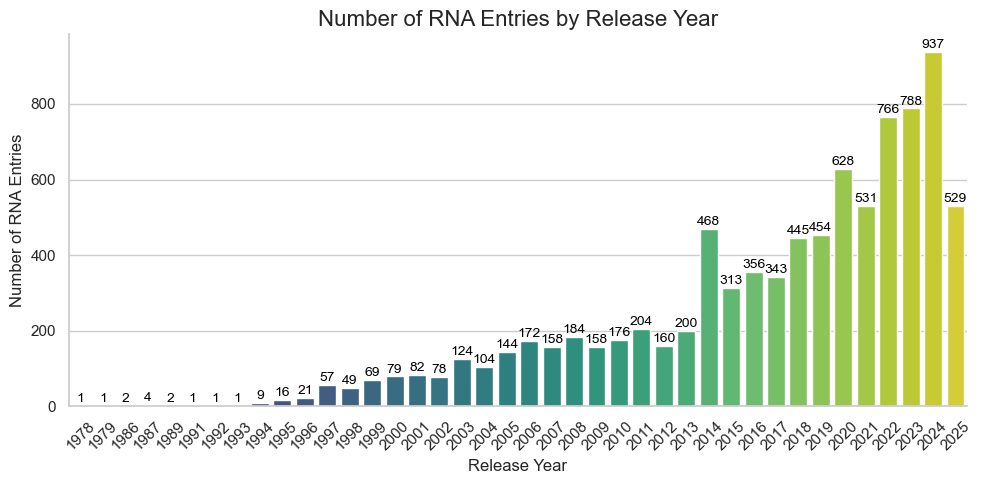

In [9]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"
def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA')
filter_terms = ['pdb_id', 'title', 'organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands','release_year']
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)

df_yearly_counts = df_results.groupby('release_year').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='release_year', ascending=True)

display_table(df_results, top_n=20)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='release_year', y='count', data=df_yearly_counts, palette='viridis')

plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of RNA Entries', fontsize=12)
plt.title('Number of RNA Entries by Release Year', fontsize=16)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()










All ready, move to next code


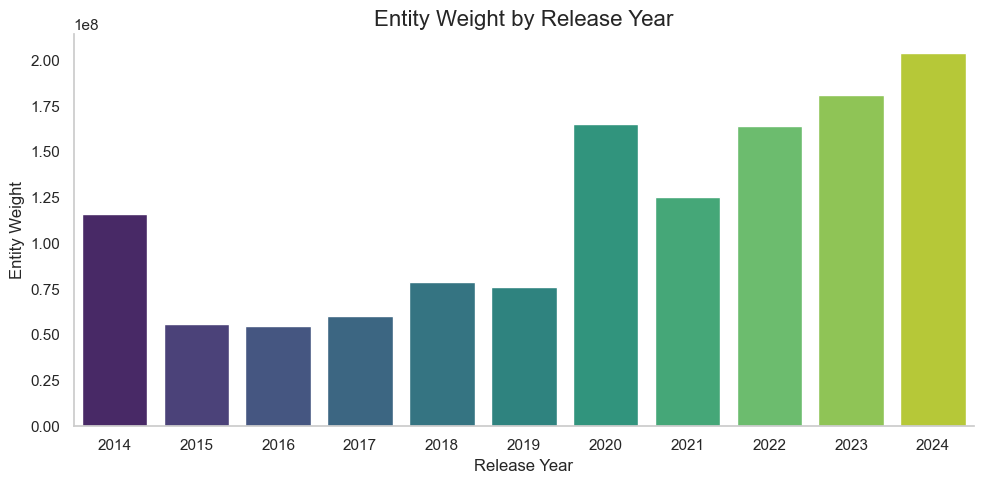

In [5]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from solrq import Q 
search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"
def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA')
filter_terms = ['pdb_id', 'title', 'organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands','release_year']
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)
#display_table(df_results, top_n=20)


df_results['release_year'] = pd.to_numeric(df_results['release_year'], errors='coerce')
#display_table(df_results, top_n=20)

#df_results['release_year'] = df_results['release_year'].dt.year
df_results['entity_weight'] = pd.to_numeric(df_results['entity_weight'], errors='coerce')

df_yearly_entity_weight = df_results.groupby('release_year')['entity_weight'].sum().reset_index()
#display_table(df_yearly_entity_weight, top_n=20)
df_selected_years = df_yearly_entity_weight[(df_yearly_entity_weight['release_year'] >= 2014) & 
                                            (df_yearly_entity_weight['release_year'] <= 2024)]
#display_table(df_selected_years)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='release_year', y='entity_weight', data=df_selected_years, palette='viridis')

plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Entity Weight', fontsize=12)
plt.title('Entity Weight by Release Year', fontsize=16)

plt.grid(False)
sns.despine()
plt.tight_layout()


All ready, move to next code


,assembly_composition,entity_weight,experimental_method,interacting_ligands,journal,organism_scientific_name,pdb_id,processing_site,release_year,title
0,RNA/protein complex,579761.940,Electron Microscopy,"MG : MAGNESIUM ION,T1C : TIGECYCLINE",Nat Commun,Saccharomyces cerevisiae,8k82,PDBJ,2024,Cryo-EM structure of the yeast 80S ribosome wi...
1,RNA/protein complex,645.454,X-ray diffraction,MN : MANGANESE (II) ION,Elife,synthetic construct,7mpq,RCSB,2021,Bartonella henselae NrnC cleaving pGG in the p...
2,RNA/protein complex,497404.970,Electron Microscopy,"MG : MAGNESIUM ION,PUT : 1,4-DIAMINOBUTANE",Nature,Escherichia coli K-12,7n2u,RCSB,2021,Elongating 70S ribosome complex in a hybrid-H1...
3,RNA/protein complex,945314.250,Electron Microscopy,"MG : MAGNESIUM ION,YQM : Eravacycline",mBio,Acinetobacter baumannii AB0057,7m4w,RCSB,2021,A. baumannii Ribosome-Eravacycline complex: Em...
4,RNA/protein complex,579635.250,Electron Microscopy,MG : MAGNESIUM ION,Sci Adv,Saccharomyces cerevisiae,8evq,RCSB,2023,Hypopseudouridylated Ribosome bound with TSV I...
5,RNA/protein complex,38951.105,Electron Microscopy,MG : MAGNESIUM ION,Sci Adv,Saccharomyces cerevisiae,8evs,RCSB,2023,Hypopseudouridylated yeast 80S bound with Taur...
6,DNA/RNA/protein complex,9700.808,Electron Microscopy,G2P : PHOSPHOMETHYLPHOSPHONIC ACID GUANYLATE E...,Proc Natl Acad Sci U S A,synthetic RNA,8ej3,RCSB,2023,M. tuberculosis RNAP pause escaped complex wit...
7,RNA/protein complex,5842.595,Electron Microscopy,NaN,Nat Commun,Escherichia coli K-12,7lv0,RCSB,2021,Pre-translocation rotated ribosome +1-frameshi...
8,RNA/protein complex,15963.094,Electron Microscopy,NaN,Science,Trypanosoma brucei,8fnk,RCSB,2023,Cryo-EM structure of RNase-untreated RESC-B in...
9,DNA/RNA/protein complex,15404.284,Electron Microscopy,PRF : 7-DEAZA-7-AMINOMETHYL-GUANINE,Nat Struct Mol Biol,Escherichia coli,8g8z,RCSB,2023,Cryo-EM structure of 3DVA component 1 of Esche...


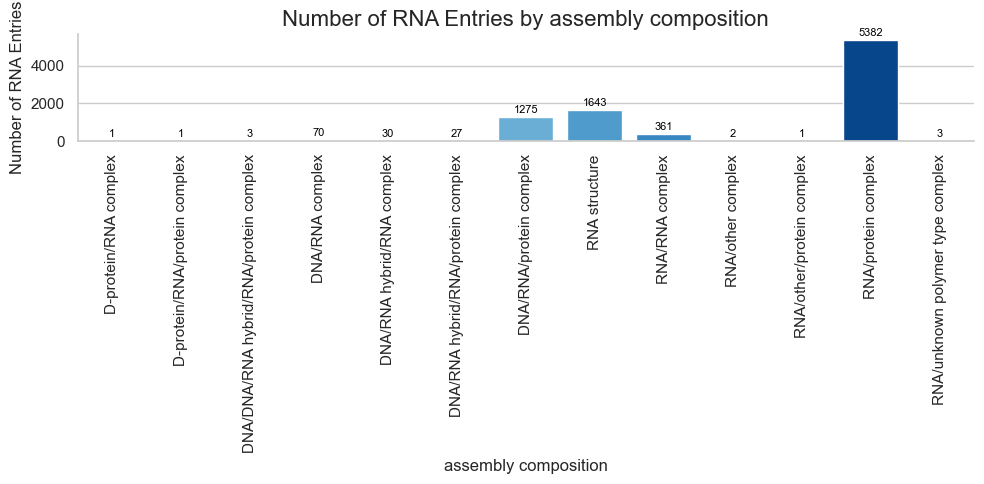

In [10]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA')
filter_terms = ['pdb_id', 'title', 'organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands','release_year']
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)

df_yearly_counts = df_results.groupby('assembly_composition').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='assembly_composition', ascending=True)

display_table(df_results, top_n=20)

# Convert 'assembly_composition' to categorical codes
df_yearly_counts['assembly_composition_code'] = pd.Categorical(df_yearly_counts['assembly_composition']).codes

norm = plt.Normalize(df_yearly_counts['assembly_composition_code'].min(), df_yearly_counts['assembly_composition_code'].max())
cmap = cm.Blues

df_yearly_counts['color'] = [cmap(norm(code)) for code in df_yearly_counts['assembly_composition_code']]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='assembly_composition', y='count', data=df_yearly_counts, palette='viridis')

for i, p in enumerate(ax.patches):
    p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('assembly composition', fontsize=12)
plt.ylabel('Number of RNA Entries', fontsize=12)
plt.title('Number of RNA Entries by assembly composition', fontsize=16)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=8, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()

All ready, move to next code


,assembly_composition,entity_weight,experimental_method,interacting_ligands,journal,organism_scientific_name,pdb_id,processing_site,release_year,title
0,RNA/protein complex,579761.940,Electron Microscopy,"MG : MAGNESIUM ION,T1C : TIGECYCLINE",Nat Commun,Saccharomyces cerevisiae,8k82,PDBJ,2024,Cryo-EM structure of the yeast 80S ribosome wi...
1,RNA/protein complex,645.454,X-ray diffraction,MN : MANGANESE (II) ION,Elife,synthetic construct,7mpq,RCSB,2021,Bartonella henselae NrnC cleaving pGG in the p...
2,RNA/protein complex,497404.970,Electron Microscopy,"MG : MAGNESIUM ION,PUT : 1,4-DIAMINOBUTANE",Nature,Escherichia coli K-12,7n2u,RCSB,2021,Elongating 70S ribosome complex in a hybrid-H1...
3,RNA/protein complex,945314.250,Electron Microscopy,"MG : MAGNESIUM ION,YQM : Eravacycline",mBio,Acinetobacter baumannii AB0057,7m4w,RCSB,2021,A. baumannii Ribosome-Eravacycline complex: Em...
4,RNA/protein complex,579635.250,Electron Microscopy,MG : MAGNESIUM ION,Sci Adv,Saccharomyces cerevisiae,8evq,RCSB,2023,Hypopseudouridylated Ribosome bound with TSV I...
5,RNA/protein complex,38951.105,Electron Microscopy,MG : MAGNESIUM ION,Sci Adv,Saccharomyces cerevisiae,8evs,RCSB,2023,Hypopseudouridylated yeast 80S bound with Taur...
6,DNA/RNA/protein complex,9700.808,Electron Microscopy,G2P : PHOSPHOMETHYLPHOSPHONIC ACID GUANYLATE E...,Proc Natl Acad Sci U S A,synthetic RNA,8ej3,RCSB,2023,M. tuberculosis RNAP pause escaped complex wit...
7,RNA/protein complex,5842.595,Electron Microscopy,NaN,Nat Commun,Escherichia coli K-12,7lv0,RCSB,2021,Pre-translocation rotated ribosome +1-frameshi...
8,RNA/protein complex,15963.094,Electron Microscopy,NaN,Science,Trypanosoma brucei,8fnk,RCSB,2023,Cryo-EM structure of RNase-untreated RESC-B in...
9,DNA/RNA/protein complex,15404.284,Electron Microscopy,PRF : 7-DEAZA-7-AMINOMETHYL-GUANINE,Nat Struct Mol Biol,Escherichia coli,8g8z,RCSB,2023,Cryo-EM structure of 3DVA component 1 of Esche...


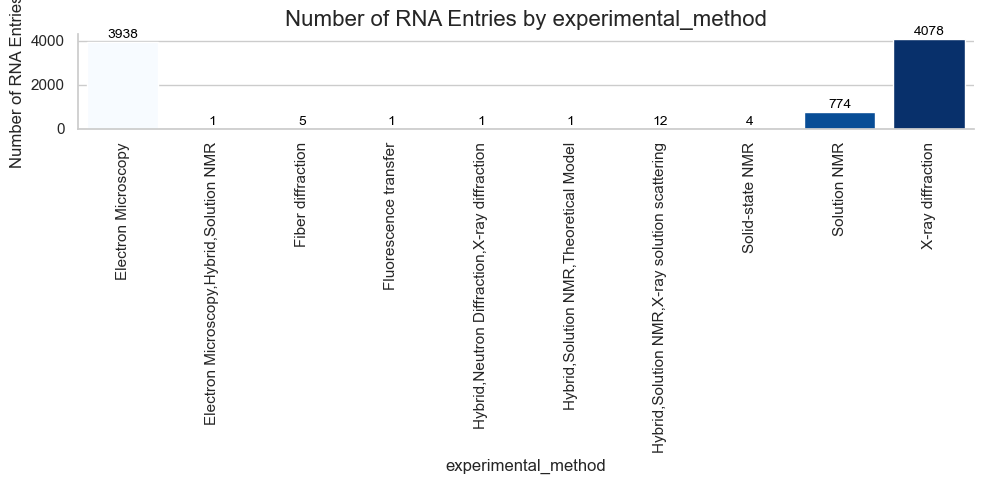

In [11]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA')
filter_terms = ['pdb_id', 'title', 'organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands','release_year']
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)

df_yearly_counts = df_results.groupby('experimental_method').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='experimental_method', ascending=True)

display_table(df_results, top_n=20)

# Convert 'experimental_method' to categorical codes
df_yearly_counts['experimental_method_code'] = pd.Categorical(df_yearly_counts['experimental_method']).codes

norm = plt.Normalize(df_yearly_counts['experimental_method_code'].min(), df_yearly_counts['experimental_method_code'].max())
cmap = cm.Blues

df_yearly_counts['color'] = [cmap(norm(code)) for code in df_yearly_counts['experimental_method_code']]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='experimental_method', y='count', data=df_yearly_counts, palette=df_yearly_counts['color'])

for i, p in enumerate(ax.patches):
    p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('experimental_method', fontsize=12)
plt.ylabel('Number of RNA Entries', fontsize=12)
plt.title('Number of RNA Entries by experimental_method', fontsize=16)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()


All ready, move to next code


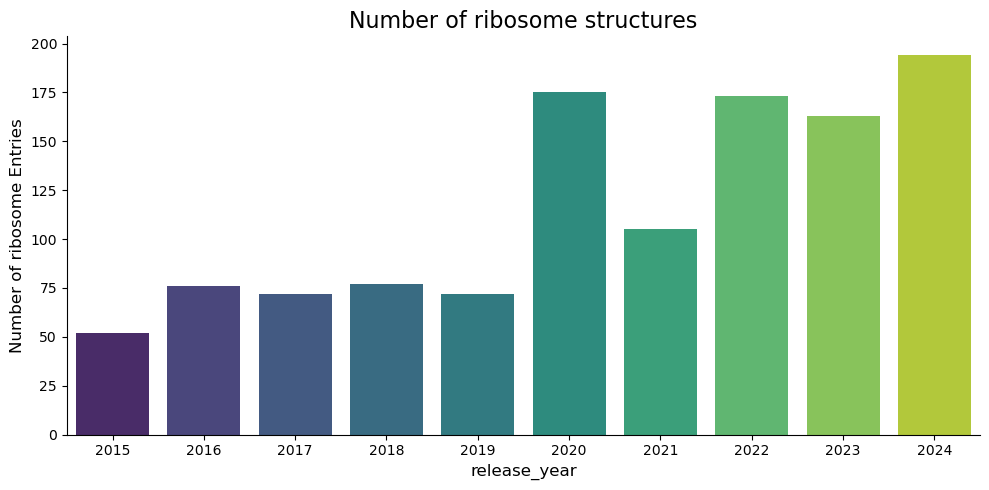

In [50]:

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA')
filter_terms = ['pdb_id', 'title', 'organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands','release_year']
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)



ribosome_count = df_results['title'].str.contains("ribosome", case=False, na=False).sum()
#print(f"Number of entries where title contains 'ribosome': {ribosome_count}")

# Filter ribosome entries (case-insensitive)
df_ribosome = df_results[df_results['title'].str.contains("ribosome", case=False, na=False)]

#Ensure release_year is numeric
df_ribosome = df_ribosome.copy()
df_ribosome.loc[:, 'release_year'] = pd.to_numeric(df_ribosome['release_year'], errors='coerce')

# Group by release year and count entries
ribosome_per_year = df_ribosome.groupby('release_year')['pdb_id'].count().reset_index()


#Filter for years between 2014 and 2024
ribosome_per_year = ribosome_per_year[
    (ribosome_per_year['release_year'] > 2014) & 
    (ribosome_per_year['release_year'] <= 2024)
]


#df_yearly_counts = df_results.groupby('assembly_composition').size().reset_index(name='count')

#df_yearly_counts = df_yearly_counts.sort_values(by='assembly_composition', ascending=True)

#display_table(df_results, top_n=20)

# Convert 'assembly_composition' to categorical codes
#df_yearly_counts['assembly_composition_code'] = pd.Categorical(df_yearly_counts['assembly_composition']).codes

#norm = plt.Normalize(df_yearly_counts['assembly_composition_code'].min(), df_yearly_counts['assembly_composition_code'].max())
#cmap = cm.Blues

#df_yearly_counts['color'] = [cmap(norm(code)) for code in df_yearly_counts['assembly_composition_code']]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='release_year', y='pdb_id', data=ribosome_per_year, palette='viridis')

#for i, p in enumerate(ax.patches):
 #   p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('release_year', fontsize=12)
plt.ylabel('Number of ribosome Entries', fontsize=12)
plt.title('Number of ribosome structures', fontsize=16)

#for p in ax.patches:
    #ax.annotate(f'{int(p.get_height())}', 
    #            (p.get_x() + p.get_width() / 2., p.get_height()), 
    #            ha='center', va='center', fontsize=10, color='black', 
    #           xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()

All ready, move to next code


,t_molecule_info,assembly_composition,entity_weight,experimental_method,interacting_ligands,journal,organism_scientific_name,pdb_id,release_year,title
0,"5S ribosomal RNA,85-mer,RNA/protein complex,he...",RNA/protein complex,38951.105,Electron Microscopy,MG : MAGNESIUM ION,Nat Commun,Saccharomyces cerevisiae,8k82,2024,Cryo-EM structure of the yeast 80S ribosome wi...
1,"56-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38790.090,Electron Microscopy,MG : MAGNESIUM ION,Nature,Escherichia coli K-12,7n2u,2021,Elongating 70S ribosome complex in a hybrid-H1...
2,"51-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,36996.992,Electron Microscopy,MG : MAGNESIUM ION,mBio,Acinetobacter baumannii AB0057,7m4w,2021,A. baumannii Ribosome-Eravacycline complex: Em...
3,"58-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38813.133,Electron Microscopy,NaN,Nat Commun,Escherichia coli K-12,7lv0,2021,Pre-translocation rotated ribosome +1-frameshi...
4,"56-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,39188.370,X-ray diffraction,MG : MAGNESIUM ION,Nat Commun,Thermus thermophilus HB8,8ev6,2023,Crystal structure of the Thermus thermophilus ...
5,"56-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38814.113,Electron Microscopy,MG : MAGNESIUM ION,Nat Struct Mol Biol,Escherichia coli,8g7r,2024,Structure of the Escherichia coli 70S ribosome...
7,"34-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38790.090,Electron Microscopy,MG : MAGNESIUM ION,ACS Cent Sci,Escherichia coli,8g6y,2023,Structure of WT E.coli ribosome 50S subunit wi...
8,"56-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,39188.370,X-ray diffraction,MG : MAGNESIUM ION,Nat Commun,Thermus thermophilus HB8,8ev7,2023,Crystal structure of the Thermus thermophilus ...
9,"58-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38814.113,Electron Microscopy,MG : MAGNESIUM ION,Nat Struct Mol Biol,Escherichia coli,8g7q,2024,Structure of the Escherichia coli 70S ribosome...
10,"55-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38814.113,Electron Microscopy,MG : MAGNESIUM ION,Nat Struct Mol Biol,Escherichia coli,8g7s,2024,Structure of the Escherichia coli 70S ribosome...


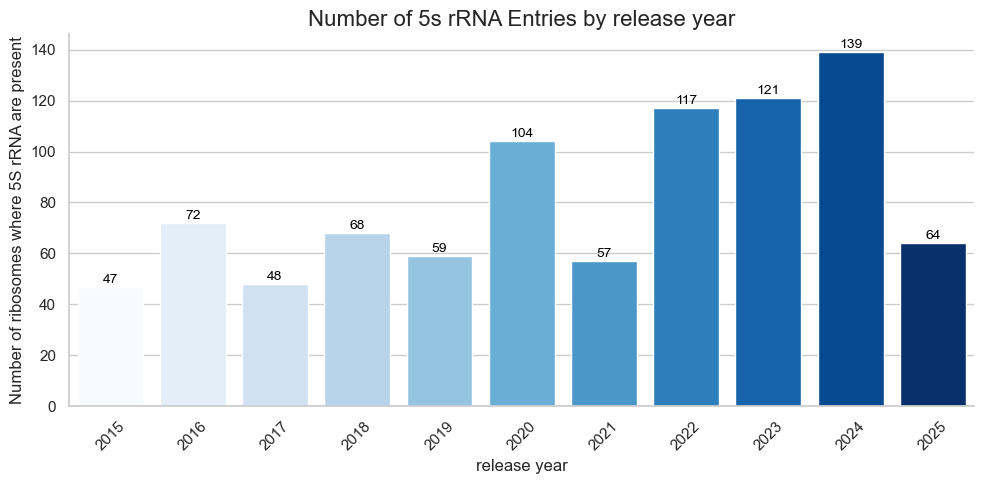

In [12]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request  (search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_name='5S ribosomal RNA')

filter_terms = ['pdb_id', 'title', 'organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition', 'assembly_polymer_count'
                'processing_site', 'entity_weight', 'interacting_ligands','release_year','t_molecule_info']


results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)

df_results = df_results[df_results['title'].str.contains('ribosome', case=False, na=False)]

display_table(df_results, top_n=20)

df_results.to_csv('RNA_all.csv', index=False)

df_filtered = df_results[(df_results['release_year'] >= 2015) & (df_results['release_year'] <= 2025)]

df_yearly_counts = df_filtered.groupby('release_year').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='release_year', ascending=True)

#df_yearly_counts['assembly_composition_code'] = pd.Categorical(df_yearly_counts['assembly_composition']).codes

norm = plt.Normalize(df_yearly_counts['release_year'].min(), df_yearly_counts['release_year'].max())
cmap = cm.Blues

df_yearly_counts['color'] = [cmap(norm(code)) for code in df_yearly_counts['release_year']]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='release_year', y='count', data=df_yearly_counts, palette='viridis')

for i, p in enumerate(ax.patches):
    p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('release year', fontsize=12)
plt.ylabel('Number of ribosomes where 5S rRNA are present', fontsize=12)
plt.title('Number of 5s rRNA Entries by release year', fontsize=16)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()



All ready, move to next code


,t_molecule_info,assembly_composition,entity_weight,experimental_method,interacting_ligands,journal,organism_scientific_name,pdb_id,release_year,title
0,"5S ribosomal RNA,85-mer,RNA/protein complex,he...",RNA/protein complex,38951.105,Electron Microscopy,MG : MAGNESIUM ION,Nat Commun,Saccharomyces cerevisiae,8k82,2024,Cryo-EM structure of the yeast 80S ribosome wi...
1,"56-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38790.090,Electron Microscopy,MG : MAGNESIUM ION,Nature,Escherichia coli K-12,7n2u,2021,Elongating 70S ribosome complex in a hybrid-H1...
2,"51-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,36996.992,Electron Microscopy,MG : MAGNESIUM ION,mBio,Acinetobacter baumannii AB0057,7m4w,2021,A. baumannii Ribosome-Eravacycline complex: Em...
3,"58-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38813.133,Electron Microscopy,NaN,Nat Commun,Escherichia coli K-12,7lv0,2021,Pre-translocation rotated ribosome +1-frameshi...
4,"56-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,39188.370,X-ray diffraction,MG : MAGNESIUM ION,Nat Commun,Thermus thermophilus HB8,8ev6,2023,Crystal structure of the Thermus thermophilus ...
5,"56-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38814.113,Electron Microscopy,MG : MAGNESIUM ION,Nat Struct Mol Biol,Escherichia coli,8g7r,2024,Structure of the Escherichia coli 70S ribosome...
7,"34-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38790.090,Electron Microscopy,MG : MAGNESIUM ION,ACS Cent Sci,Escherichia coli,8g6y,2023,Structure of WT E.coli ribosome 50S subunit wi...
8,"56-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,39188.370,X-ray diffraction,MG : MAGNESIUM ION,Nat Commun,Thermus thermophilus HB8,8ev7,2023,Crystal structure of the Thermus thermophilus ...
9,"58-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38814.113,Electron Microscopy,MG : MAGNESIUM ION,Nat Struct Mol Biol,Escherichia coli,8g7q,2024,Structure of the Escherichia coli 70S ribosome...
10,"55-mer,5S ribosomal RNA,RNA/protein complex,he...",RNA/protein complex,38814.113,Electron Microscopy,MG : MAGNESIUM ION,Nat Struct Mol Biol,Escherichia coli,8g7s,2024,Structure of the Escherichia coli 70S ribosome...


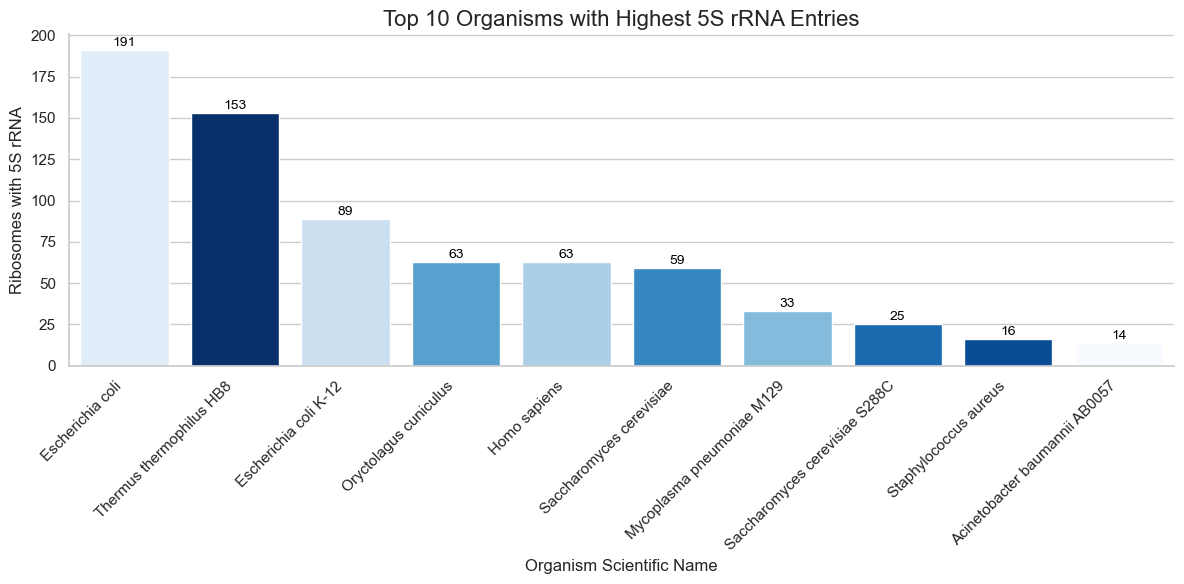

In [13]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request  (search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_name='5S ribosomal RNA')

filter_terms = ['pdb_id', 'title', 'organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition', 'assembly_polymer_count'
                'processing_site', 'entity_weight', 'interacting_ligands','release_year','t_molecule_info']


results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)

df_results = df_results[df_results['title'].str.contains('ribosome', case=False, na=False)]

display_table(df_results, top_n=20)

df_results.to_csv('RNA_all.csv', index=False)

df_filtered = df_results[(df_results['release_year'] >= 2015) & (df_results['release_year'] <= 2025)]

df_yearly_counts = df_filtered.groupby('organism_scientific_name').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='organism_scientific_name', ascending=True)

df_yearly_counts['organism_code'] = pd.Categorical(df_yearly_counts['organism_scientific_name']).codes

# Get the top 10 organisms with the highest count
df_top10 = df_yearly_counts.sort_values(by='count', ascending=False).head(10)

# Recalculate color mapping for just the top 10
df_top10['organism_code'] = pd.Categorical(df_top10['organism_scientific_name']).codes
norm = plt.Normalize(df_top10['organism_code'].min(), df_top10['organism_code'].max())
cmap = cm.Blues
df_top10['color'] = [cmap(norm(code)) for code in df_top10['organism_code']]

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='organism_scientific_name', y='count', data=df_top10, palette='viridis')

# Apply colors
for i, p in enumerate(ax.patches):
    p.set_facecolor(df_top10['color'].iloc[i])

# Label the axes and title
plt.xlabel('Organism Scientific Name', fontsize=12)
plt.ylabel('Ribosomes with 5S rRNA', fontsize=12)
plt.title('Top 10 Organisms with Highest 5S rRNA Entries', fontsize=16)

# Annotate bars with count values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Improve x-axis readability
plt.xticks(rotation=45, ha='right')  
sns.despine()
plt.tight_layout()
plt.show()


All ready, move to next code


,t_molecule_info,assembly_composition,entity_weight,experimental_method,interacting_ligands,journal,organism_scientific_name,pdb_id,release_year,title
0,"23S ribosomal RNA,85-mer,RNA/protein complex,h...",RNA/protein complex,1097493.90,Electron Microscopy,"MG : MAGNESIUM ION,SPD : SPERMIDINE,T1C : TIGE...",Nat Commun,Saccharomyces cerevisiae,8k82,2024,Cryo-EM structure of the yeast 80S ribosome wi...
1,"23S ribosomal RNA,56-mer,RNA/protein complex,h...",RNA/protein complex,941811.56,Electron Microscopy,"ATP : ADENOSINE-5'-TRIPHOSPHATE,MG : MAGNESIUM...",Nature,Escherichia coli K-12,7n2u,2021,Elongating 70S ribosome complex in a hybrid-H1...
2,"23S ribosomal RNA,51-mer,RNA/protein complex,h...",RNA/protein complex,945314.25,Electron Microscopy,"MG : MAGNESIUM ION,YQM : Eravacycline",mBio,Acinetobacter baumannii AB0057,7m4w,2021,A. baumannii Ribosome-Eravacycline complex: Em...
3,"23S ribosomal RNA,58-mer,RNA/protein complex,h...",RNA/protein complex,941305.25,Electron Microscopy,"FME : N-FORMYLMETHIONINE,PRO : PROLINE",Nat Commun,Escherichia coli K-12,7lv0,2021,Pre-translocation rotated ribosome +1-frameshi...
4,"23S ribosomal RNA,56-mer,RNA/protein complex,h...",RNA/protein complex,948035.60,X-ray diffraction,"AKN : (2S)-N-[(1R,2S,3S,4R,5S)-4-[(2R,3R,4S,5S...",Nat Commun,Thermus thermophilus HB8,8ev6,2023,Crystal structure of the Thermus thermophilus ...
5,"23S ribosomal RNA,56-mer,RNA/protein complex,h...",RNA/protein complex,941811.56,Electron Microscopy,"ILE : ISOLEUCINE,MG : MAGNESIUM ION",Nat Struct Mol Biol,Escherichia coli,8g7r,2024,Structure of the Escherichia coli 70S ribosome...
6,"23S ribosomal RNA,53-mer,RNA/protein complex,h...",RNA/protein complex,948021.60,X-ray diffraction,"ARG : ARGININE,HGR : Hygromycin A,MG : MAGNESI...",Nat Commun,Thermus thermophilus HB8,8fc3,2023,Crystal structure of the Thermus thermophilus ...
7,"23S ribosomal RNA,34-mer,RNA/protein complex,h...",RNA/protein complex,941811.56,Electron Microscopy,8AN : 3'-amino-3'-deoxyadenosine 5'-(dihydroge...,ACS Cent Sci,Escherichia coli,8g6y,2023,Structure of WT E.coli ribosome 50S subunit wi...
8,"23S ribosomal RNA,58-mer,RNA/protein complex,h...",RNA/protein complex,941811.56,Electron Microscopy,"ILE : ISOLEUCINE,MG : MAGNESIUM ION",Nat Struct Mol Biol,Escherichia coli,8g7q,2024,Structure of the Escherichia coli 70S ribosome...
9,"23S ribosomal RNA,55-mer,RNA/protein complex,h...",RNA/protein complex,941811.56,Electron Microscopy,"ILE : ISOLEUCINE,MG : MAGNESIUM ION",Nat Struct Mol Biol,Escherichia coli,8g7s,2024,Structure of the Escherichia coli 70S ribosome...


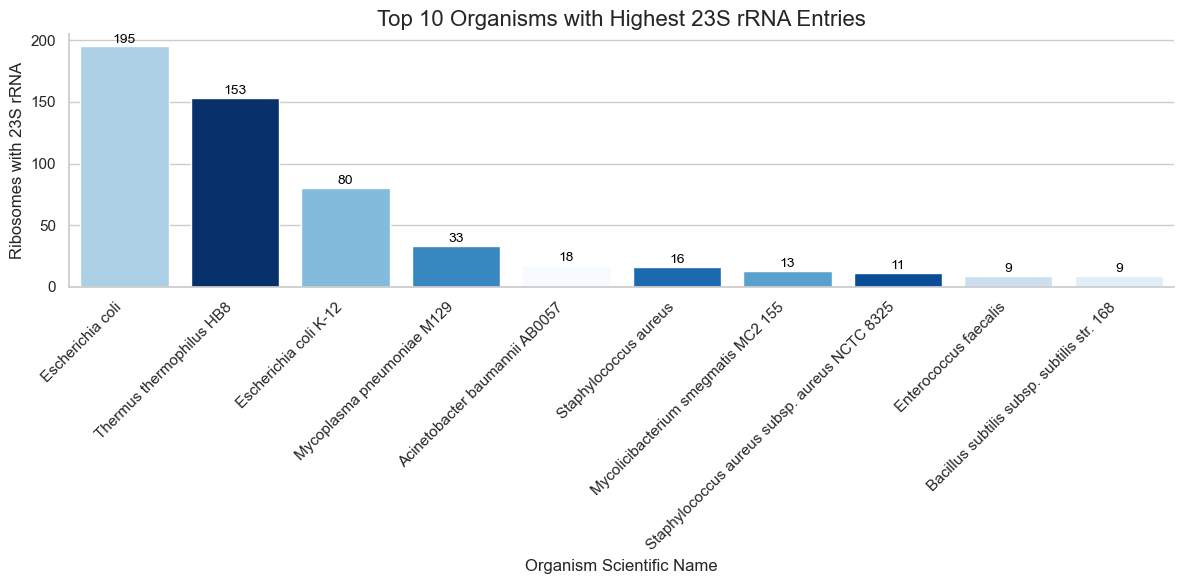

In [14]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request  (search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_name='23S ribosomal RNA')

filter_terms = ['pdb_id', 'title', 'organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition', 'assembly_polymer_count'
                'processing_site', 'entity_weight', 'interacting_ligands','release_year','t_molecule_info']


results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)

df_results = df_results[df_results['title'].str.contains('ribosome', case=False, na=False)]

display_table(df_results, top_n=20)

df_results.to_csv('RNA_all.csv', index=False)

df_filtered = df_results[(df_results['release_year'] >= 2015) & (df_results['release_year'] <= 2025)]

df_yearly_counts = df_filtered.groupby('organism_scientific_name').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='organism_scientific_name', ascending=True)

df_yearly_counts['organism_code'] = pd.Categorical(df_yearly_counts['organism_scientific_name']).codes

# Get the top 10 organisms with the highest count
df_top10 = df_yearly_counts.sort_values(by='count', ascending=False).head(10)

# Recalculate color mapping for just the top 10
df_top10['organism_code'] = pd.Categorical(df_top10['organism_scientific_name']).codes
norm = plt.Normalize(df_top10['organism_code'].min(), df_top10['organism_code'].max())
cmap = cm.Blues
df_top10['color'] = [cmap(norm(code)) for code in df_top10['organism_code']]

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='organism_scientific_name', y='count', data=df_top10, palette='viridis')

# Apply colors
for i, p in enumerate(ax.patches):
    p.set_facecolor(df_top10['color'].iloc[i])

# Label the axes and title
plt.xlabel('Organism Scientific Name', fontsize=12)
plt.ylabel('Ribosomes with 23S rRNA', fontsize=12)
plt.title('Top 10 Organisms with Highest 23S rRNA Entries', fontsize=16)

# Annotate bars with count values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Improve x-axis readability
plt.xticks(rotation=45, ha='right')  
sns.despine()
plt.tight_layout()
plt.show()


All ready, move to next code


,assembly_composition,entity_weight,experimental_method,journal,organism_scientific_name,pdb_id,processing_site,release_year,rfam,title,interacting_ligands,rfam_id,rfam_name
0,RNA/protein complex,24818.893,Electron Microscopy,Nature,Escherichia coli,5lzf,PDBE,2016,RF00005 : tRNA,Structure of the 70S ribosome with fMetSec-tRN...,NaN,RF00005,tRNA
2,RNA/protein complex,498908.840,Electron Microscopy,Nature,Escherichia coli,5lzc,PDBE,2016,RF00177 : Bacterial small subunit ribosomal RNA,Structure of SelB-Sec-tRNASec bound to the 70S...,NaN,RF00177,Bacterial small subunit ribosomal RNA
5,RNA/protein complex,24436.550,Electron Microscopy,Cell,Oryctolagus cuniculus,5lzw,PDBE,2016,RF00005 : tRNA,Structure of the mammalian rescue complex with...,NaN,RF00005,tRNA
7,RNA/protein complex,494168.780,X-ray diffraction,To be published,Thermus thermophilus HB8,6caq,RCSB,2018,RF00177 : Bacterial small subunit ribosomal RNA,Crystal Structure of 30S ribosomal subunit fro...,"EUS : N-[(1R,2S,3S,4R,5S)-5-amino-4-{[(2S,3R)-...",RF00177,Bacterial small subunit ribosomal RNA
8,RNA/protein complex,24436.550,Electron Microscopy,Cell,Oryctolagus cuniculus,5lzu,PDBE,2016,RF00005 : tRNA,Structure of the mammalian ribosomal terminati...,NaN,RF00005,tRNA
9,RNA/protein complex,500263.220,Electron Microscopy,EMBO J,Bacillus subtilis subsp. subtilis str. 168,5njt,PDBE,2017,RF00177 : Bacterial small subunit ribosomal RNA,Structure of the Bacillus subtilis hibernating...,NaN,RF00177,Bacterial small subunit ribosomal RNA
10,RNA/protein complex,948035.600,X-ray diffraction,J Mol Biol,Thermus thermophilus HB8,6cfl,RCSB,2018,RF02541 : Bacterial large subunit ribosomal RNA,Crystal structure of the Thermus thermophilus ...,"ARG : ARGININE,EZM : N-[(1R,2R)-1,3-dihydroxy-...",RF02541,Bacterial large subunit ribosomal RNA
11,RNA/protein complex,497404.970,Electron Microscopy,Sci Rep,Escherichia coli,6c4i,RCSB,2018,RF00177 : Bacterial small subunit ribosomal RNA,Conformation of methylated GGQ in the peptidyl...,MG : MAGNESIUM ION,RF00177,Bacterial small subunit ribosomal RNA
13,RNA/protein complex,498908.840,Electron Microscopy,Nature,Escherichia coli,5lze,PDBE,2016,RF00177 : Bacterial small subunit ribosomal RNA,Structure of the 70S ribosome with Sec-tRNASec...,NaN,RF00177,Bacterial small subunit ribosomal RNA
15,RNA/protein complex,489638.880,X-ray diffraction,Nucleic Acids Res,Thermus thermophilus HB8,6buw,RCSB,2018,RF00177 : Bacterial small subunit ribosomal RNA,Thermus thermophilus 70S complex containing 16...,MG : MAGNESIUM ION,RF00177,Bacterial small subunit ribosomal RNA


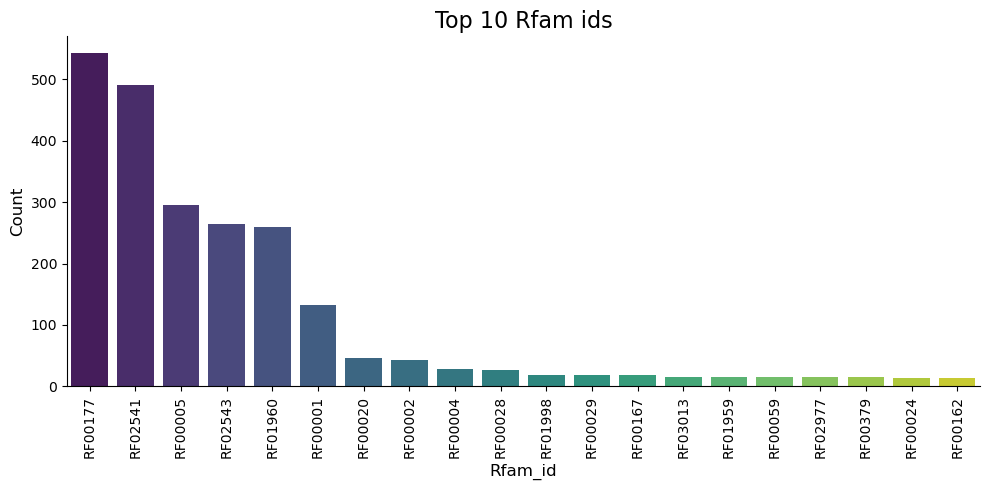

In [14]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA')
filter_terms = ['pdb_id', 'title', 'release_year', 'rfam','organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands',]
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)
df_results = df_results.dropna(subset=['rfam'])



# Split the 'rfam' column into two new columns
df_results[['rfam_id', 'rfam_name']] = df_results['rfam'].str.split(':', n=1, expand=True)

# strip extra whitespace
df_results['rfam_id'] = df_results['rfam_id'].str.strip()
df_results['rfam_name'] = df_results['rfam_name'].str.strip()

display_table(df_results, top_n=20)

df_results['release_year'] = pd.to_numeric(df_results['release_year'], errors='coerce')

# Filter for years 2014 to 2024
df_filtered = df_results[(df_results['release_year'] >= 2014) & (df_results['release_year'] <= 2024)]

# Drop NaNs in rfam_id (optional but recommended)
df_filtered = df_filtered.dropna(subset=['rfam_id'])

# Count rfam_id occurrences
rfam_counts = df_filtered['rfam_id'].value_counts()

# Get top 10 Rfam IDs by count
top_rfam_counts = rfam_counts.head(20).reset_index()
top_rfam_counts.columns = ['rfam_id', 'count']

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='rfam_id', y='count', data=top_rfam_counts, palette='viridis')

#for i, p in enumerate(ax.patches):
 #   p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('Rfam_id', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Top 10 Rfam ids', fontsize=16)

#for p in ax.patches:
    #ax.annotate(f'{int(p.get_height())}', 
    #            (p.get_x() + p.get_width() / 2., p.get_height()), 
    #            ha='center', va='center', fontsize=10, color='black', 
    #           xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()


All ready, move to next code


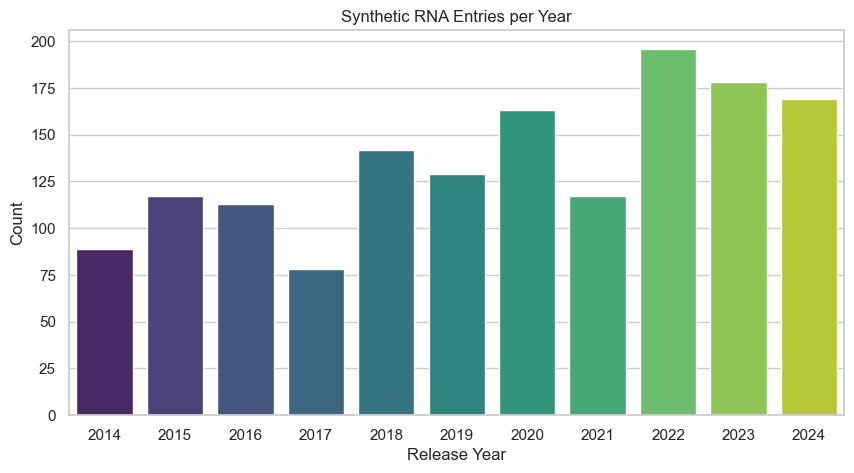

In [15]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA', organism_name= 'synthetic construct')
filter_terms = ['pdb_id', 'title', 'release_year', 'rfam','organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands',]
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)



df_results = pandas_dataset(results)

df_results = df_results.dropna(subset=['release_year'])

# Convert year to numeric
df_results['release_year'] = pd.to_numeric(df_results['release_year'], errors='coerce')

# Filter by year
df_recent = df_results[(df_results['release_year'] >= 2014) & (df_results['release_year'] <= 2024)]

# Count per year
yearly_counts = df_recent.groupby('release_year').size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=yearly_counts, x='release_year', y='count', palette='viridis')
# Annotate bars with count values
for index, row in yearly_counts.iterrows():
    ax.text(index, row['count'] + 1, f"{row['count']}", color='black', ha="center")

plt.title("Synthetic RNA Entries per Year")
plt.ylabel("Count")
plt.xlabel("Release Year")
plt.show()


All ready, move to next code


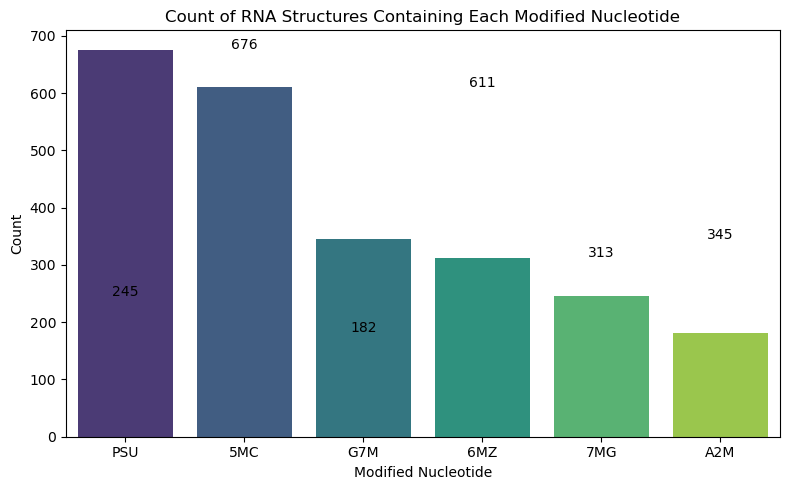

In [79]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA')
filter_terms = ['pdb_id', 'title', 'release_year', 'rfam','organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands', 'compound_name']

results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)
df_results = df_results.dropna(subset=['interacting_ligands'])

df_results.head(20)

# Define your list of modifications
modifications = ['7MG', "PSU", "A2M", "5MC", "6MZ", 'G7M']

# Create a regex pattern
pattern = "|".join(modifications)

# Filter entries that contain any of the modifications
df_mods = df_results[df_results['compound_name'].str.contains(pattern, na=False)]

# Count how many entries mention each modification
mod_counts = {}
for mod in modifications:
    mod_counts[mod] = df_mods['compound_name'].str.contains(mod, na=False).sum()

# Convert to DataFrame for plotting
df_mod_counts = pd.DataFrame(list(mod_counts.items()), columns=["modification", "count"])

# Sort by count descending (optional)
df_mod_counts = df_mod_counts.sort_values(by="count", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_mod_counts, x="modification", y="count", palette="viridis")

# Add count labels on top
for index, row in df_mod_counts.iterrows():
    ax.text(index, row['count'] + 0.5, f"{row['count']}", color='black', ha="center")

plt.title("Count of RNA Structures Containing Each Modified Nucleotide")
plt.ylabel("Count")
plt.xlabel("Modified Nucleotide")
plt.tight_layout()
plt.show()


All ready, move to next code
6      5MC
24     OMG
14     5MU
22     OMC
29     UR3
      ... 
324    5IU
169    MGP
186    2HP
312    75B
301    PPS
Name: short_label, Length: 140, dtype: object


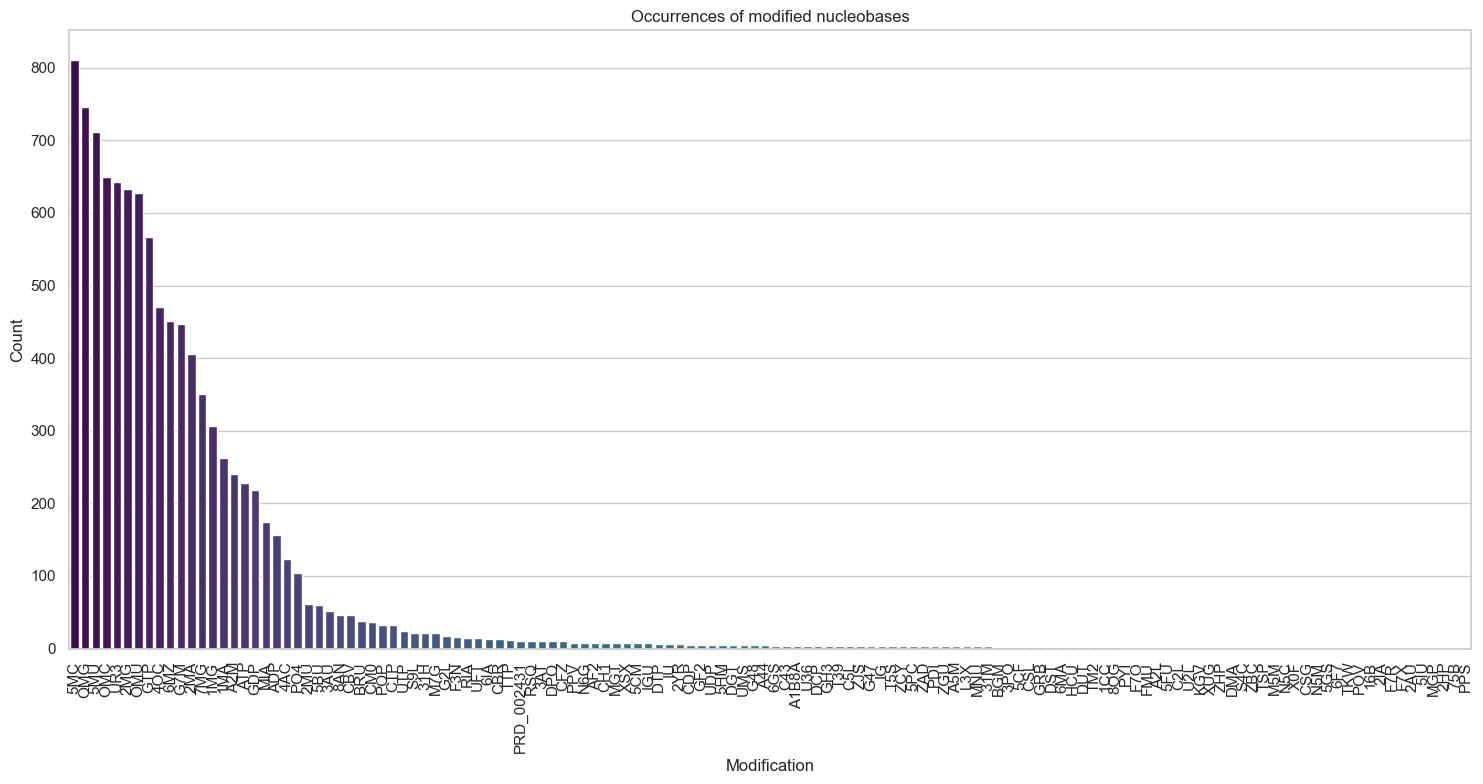

In [16]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 
import collections

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA')
filter_terms = ['pdb_id', 'title', 'release_year', 'rfam','organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands', 'compound_name']

results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)


# Drop NaNs
compound_series = df_results['compound_name'].dropna()


# Initialize a counter to store occurrences of 'ribo'-containing terms
ribo_counter = collections.Counter()

# Split strings and count terms containing 'ribo'
for entry in compound_series:
    terms = [term.strip() for term in entry.split(',')]
    for term in terms:
        if 'phosphate' in term.lower():  # case-insensitive match
            ribo_counter[term] += 1

# Convert counter to DataFrame
df_ribo_mods = pd.DataFrame(ribo_counter.items(), columns=['modification', 'count'])

# Sort by count
df_ribo_mods = df_ribo_mods.sort_values(by='count', ascending=False)



# Keep only modifications that contain a colon
df_ribo_mods = df_ribo_mods[df_ribo_mods['modification'].str.contains(":", na=False)]


# Create a short label column (first part before ":" if exists)
df_ribo_mods['short_label'] = df_ribo_mods['modification'].apply(lambda x: x.split(':')[0].strip())
print(df_ribo_mods['short_label'])

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=df_ribo_mods, x='short_label', y='count', palette='viridis')



plt.title("Occurrences of modified nucleobases")
plt.xticks(rotation=90, ha='center')
plt.xlabel("Modification")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


All ready, move to next code


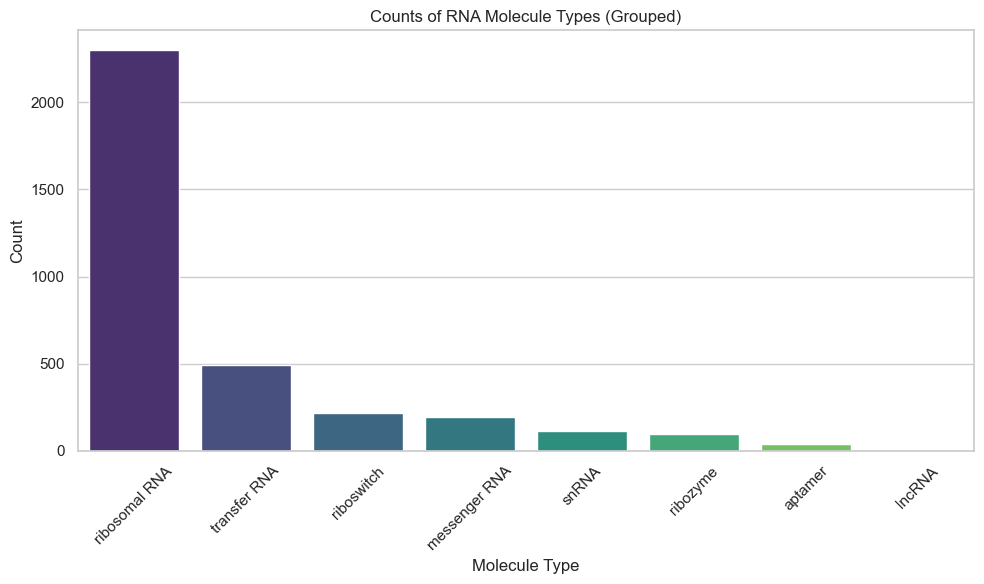

In [23]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q 
import collections

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"

def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

search_terms = Q(status="REL", molecule_type='RNA') & Q(status="REL", GO_mapping="GO:0002151")
filter_terms = ['pdb_id', 'title', 'release_year', 'rfam','organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands', 'compound_name', 'molecule_name']

results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)
df_results.head(20)

# Drop NaNs and make lowercase
if 'molecule_name' in df_results.columns:
    molecule_series = df_results['molecule_name'].dropna().str.lower()

# Mapping keywords to desired categories
category_map = {
    'rrna': 'ribosomal RNA',
    'ribosomal rna': 'ribosomal RNA',
    'trna': 'transfer RNA',
    'transfer rna': 'transfer RNA',
    'mrna': 'messenger RNA',
    'messenger rna': 'messenger RNA',
    'ribozyme': 'ribozyme',
    'riboswitch': 'riboswitch',
    'RNA quadruplex': 'quadruplex',
    'aptamer': 'aptamer',
    'snrna': 'snRNA',
    'lncrna': 'lncRNA',
    'crrna': 'crRNA'
}



# Initialize Counter
from collections import Counter
category_counts = Counter()

# Loop through entries and count based on category_map
for entry in molecule_series:
    for keyword, category in category_map.items():
        if keyword in entry:
            category_counts[category] += 1
            break  # Only count once per entry

# Convert to DataFrame
category_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['count']).reset_index()
category_df.columns = ['molecule_type', 'count']
category_df = category_df.sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=category_df, x='molecule_type', y='count', palette='viridis')
plt.title('Counts of RNA Molecule Types (Grouped)')
plt.xlabel('Molecule Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()